# Data Preprocessing

## cluster stations

上次的作業沒有對station分類出來，所以我這邊先處理一下


```python
import pandas as pd

data=pd.read_csv('./new_data.csv')


out=data.loc[:,['end station id','end station name','end station latitude','end station longitude']]
out=out.drop_duplicates('end station id').sort_values('end station id')
out.to_csv('station_data.csv',index=False);
```

再來create和匯入DB

```sql
create table station(
id varchar(10),
name varchar(100),
latitude float,
longitude float,
primary key(id),
index(id)
);

load data local infile './station_data.csv'
into table station
fields terminated by ','
enclosed by '"'
lines terminated by '\n'
ignore 1 lines;
```

# First mining task - - - ( in_flow,out_flow )

首先先用 in_flow與out_flow 當作transaction


為了要找出該怎麼要用哪個discretization method，我先SQL出資料中，以in_flow,out_flow去group的data，查看各group出現次數比例
```sql
select *,count(*) from iodata where id=519 group by in_c,out_c order by count(*) desc;
```
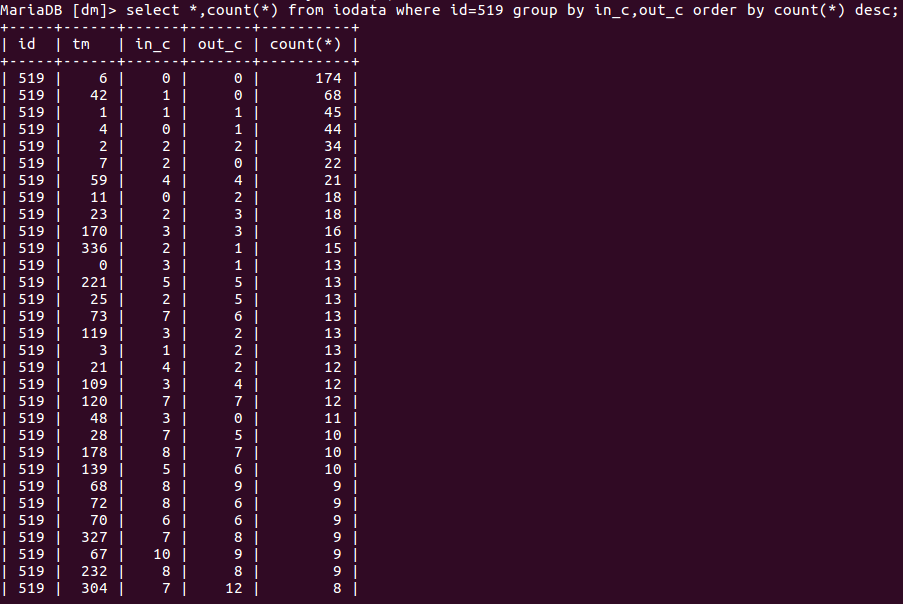
前段資料多介於0~10次之間，且(0,0)組合佔相當大的比例

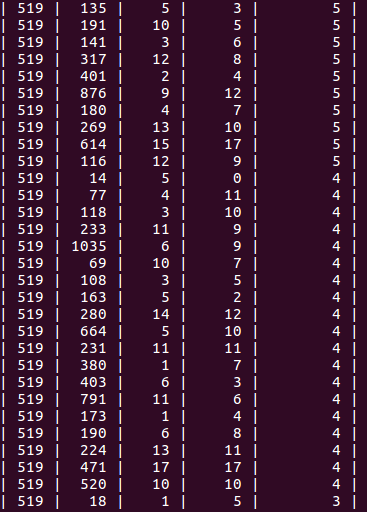
中段資料大多in_c,out_c其中之一超過10

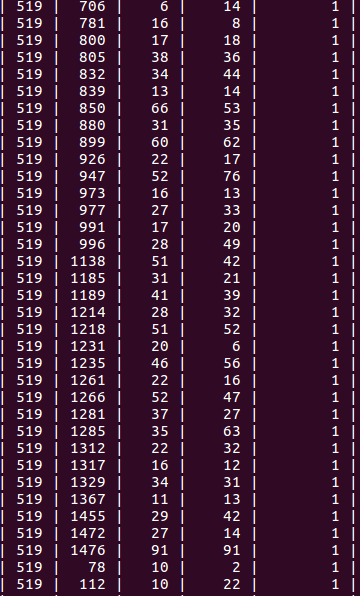
後段資料已經是極度不平均的分佈

觀察資料後決定以value/5來分群，並且省略計算值為(0,0)的transaction

由於citibike大概都是暫時性的交通替代方式，不太會有短時間內大量的租借情況，因此預估結果大概會是由(0,0),(0,1),(1,0),(1,1)佔大部份的比例

In [7]:
import pandas as pd
from mlxtend.preprocessing import OnehotTransactions
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

data=pd.read_csv('./inout_flow_data.csv')
data=data.loc[(data['station_id']==519) & ((data['in_flow_count']!=0) | (data['out_flow_count']!=0)),['in_flow_count','out_flow_count']]

lst=[]
for value in data.itertuples():
	lst.append(['i'+str(int(value[1]/5)),'o'+str(int(value[2]/5))])	

oht=OnehotTransactions()
oht_ary=oht.fit(lst).transform(lst)
df=pd.DataFrame(oht_ary,columns=oht.columns_)
frequent_itemsets=apriori(df,min_support=0.04,use_colnames=True)
print(frequent_itemsets)

     support  itemsets
0   0.393455      [i0]
1   0.266362      [i1]
2   0.128615      [i2]
3   0.047945      [i3]
4   0.392694      [o0]
5   0.264840      [o1]
6   0.126332      [o2]
7   0.050989      [o3]
8   0.040335      [o4]
9   0.315830  [i0, o0]
10  0.058600  [i0, o1]
11  0.065449  [i1, o0]
12  0.137747  [i1, o1]
13  0.052511  [i1, o2]
14  0.060122  [i2, o1]


這邊忽略只有一個元素的itemset，以support值來看Top 3 rules的話：
1. [i0, o0]　Support：0.315830
2. [i1, o1]　Support：0.137747
3. [i1, o0]　Support：0.065449

可以觀察到，前三高皆為小量的租還數，而且在support超過0.03的transaction中，in_flow_count與out_flow_count的差都不會超過5，因此大概不太會有車站借不到車或者是還不了車的情況發生。

而這邊不看confidence的值，是因為我只想知道這樣組合出現的比例如何，並沒有要看in,out count的關係如何

由於前段資料太密集，不太好看出前段的詳細資訊與後段的整體比例，因此我這次將count < 10的數字除以2來更加區分，count > 10則除以10來放寬association標準

In [1]:
import pandas as pd
from orangecontrib.associate.fpgrowth import * 
from mlxtend.preprocessing import OnehotTransactions

data=pd.read_csv('./inout_flow_data.csv')
data=data.loc[(data['station_id']==519) & ((data['in_flow_count']!=0) | (data['out_flow_count']!=0)),['in_flow_count','out_flow_count']]

lst=[]
for value in data.itertuples():
	if(value[1]<10):
		a=value[1]/2+1
	else:
		a=6+(value[1]-10)/10
	if(value[2]<10):
		b=value[2]/2+1
	else:
		b=6+(value[2]-10)/10
	lst.append([int(a),int(b)*-1])

itemsets = frequent_itemsets(lst,0.05)
a=list(itemsets)
for i in a:
	if(len(i[0])>1):
		print(i[0],' '+str(round(i[1]/len(lst),6)))

frozenset({1, -1})  0.119482
frozenset({2, -2})  0.061644
frozenset({-6, 6})  0.083714


這次改成利用FP-growth來建立frequent itemset，並將編號改成從1與-1開始，分別代表in_count_flow與out_come_flow

可以看到support超過0.5的剛好正式前三名
1. {1, -1}　Support：0.119482
2. {2, -2}　Support：0.083714
3. {-6, 6}　Support：0.061644

比較令我訝異的事{-6, 6}這個組合，換算下來是in_flow_count與out_flow_count皆介於10~20的情況，竟然能拿到第二高的support值

以這邊的結果和上一個的結果結合，可以發現(10~20,10~20)的組合其實佔了一定的數目，不過因為分佈的很鬆散，所以上一個結果才沒有顯示出來。

但也沒有什麼不合理的點，半小時內的租借達到十幾可能是巔峰時段，例如以此為交通工具的學生、上班族的交通時間，或者是假日、特殊節日時的租借還情況。

# Second mining task - - - ( station_latitude,station_longitude )

這次我想利用車站的經緯度，來看車站的分佈情況

首先先用SQL看最大和最小的數值，決定discretization的方法
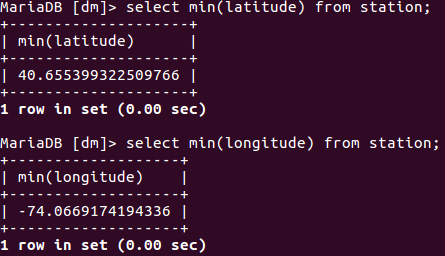
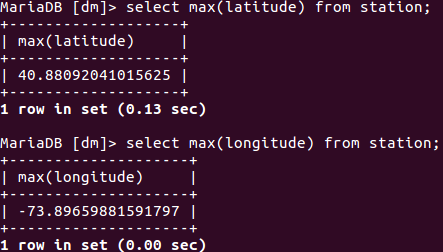

latitude <br>
最小：40.655399322509766 <br>
最大：40.88092041015625
         
longitude <br>
最小：-74.0669174194336 <br>
最大：-73.89659881591797

station數：634

因此我決定先用0.01當作discretization每個值的距離

In [8]:
import pandas as pd
from mlxtend.preprocessing import OnehotTransactions
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

data=pd.read_csv('./station_data.csv')
data=data.loc[:,['end station latitude','end station longitude']]

lst=[]
for value in data.itertuples():
	lst.append([(int((value[1]-40.655399322509766)/0.01)),int(((value[2]+73.89659881591797)/0.01))])

oht=OnehotTransactions()
oht_ary=oht.fit(lst).transform(lst)
df=pd.DataFrame(oht_ary,columns=oht.columns_)
frequent_itemsets=apriori(df,min_support=0.02,use_colnames=True)

for i in frequent_itemsets.itertuples():
	if(len(i[2])>1):
		print(str(i[1])+' '+str(i[2]))

0.0220820189274 [-9, 3]
0.0220820189274 [-9, 6]
0.0236593059937 [-9, 7]
0.0205047318612 [-8, 6]


這裡取的minimum support是0.2，可以看到前三名分別是
1. [-9, 7]　Support：0.0236593059937
2. [-9, 3]　Support：0.0220820189274
3. [-9, 6]　Support：0.0220820189274

這邊同樣也只看support值來決定Top 3 rules，原因也是因為沒有要觀察latitude與longtitude的關係

令我好奇的是第二名和第三名的support值竟然一樣，於是我將discretization的值切的更小，到0.001試試看

In [9]:
import pandas as pd
from mlxtend.preprocessing import OnehotTransactions
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

data=pd.read_csv('./station_data.csv')
data=data.loc[:,['end station latitude','end station longitude']]

lst=[]
for value in data.itertuples():
	lst.append([(int((value[1]-40.655399322509766)/0.001)),int(((value[2]+73.89659881591797)/0.001))])

oht=OnehotTransactions()
oht_ary=oht.fit(lst).transform(lst)
df=pd.DataFrame(oht_ary,columns=oht.columns_)
frequent_itemsets=apriori(df,min_support=0.002,use_colnames=True)

for i in frequent_itemsets.itertuples():
	if(len(i[2])>1):
		print(str(i[1])+' '+str(i[2]))

0.00315457413249 [-110, 87]
0.00315457413249 [-97, 103]
0.00315457413249 [-91, 93]
0.00315457413249 [-81, 96]
0.00315457413249 [-54, 70]


這結果讓我開始懷疑自己的code是不是有bug了，竟然有這麼多組資料都是一樣的support值，而且分佈換算下來，也不是落在0.01分法結果的區間內

我自己對這個結果的解釋：<br>
一、當時在設置車站的時候有限制設置的站數<br>
二、只是巧合

不過仔細觀察數據之後，發現總站數是634，而634\*0.00315457413249=2，是十分合理的<br>
而上面用0.01來切的結果，634\*0.0220820189274=14，這樣的站數重複也還算是可以接受，所以應該就真的只是巧合

由上面的例子我發現，在資料很少的情況下，切太細之後的資料反而沒有參考價值，因此我這次決定用0.02來切切看

In [13]:
import pandas as pd
from orangecontrib.associate.fpgrowth import * 
from mlxtend.preprocessing import OnehotTransactions

data=pd.read_csv('./station_data.csv')
data=data.loc[:,['end station latitude','end station longitude']]

lst=[]
for value in data.itertuples():
	lst.append([(int((value[1]-40.655399322509766)/0.02)),int(((value[2]+73.89659881591797)/0.02))])

itemsets = frequent_itemsets(lst,0.05)
a=list(itemsets)
for i in a:
	if(len(i[0])>1):
		print(str(i[0])+' '+str(i[1])+' '+str(round(i[1]/634,6)))

frozenset({1, -4}) 44 0.069401
frozenset({3, -5}) 33 0.05205
frozenset({3, -4}) 50 0.078864
frozenset({-4, 4}) 46 0.072555
frozenset({-4, 5}) 32 0.050473
frozenset({5, -3}) 32 0.050473


這次是用FP-growth來建frequent itemset，而用0.02去切的前三名是
1. {3, -4}　次數：50　Support：0.078864
2. {4, -4}　次數：46　Support：0.072555
3. {1, -4}　次數：44　Support：0.069401

從這邊的結果和上面用0.01去切的來看，可以看出這些地方車站分佈的密集程度，若再結合其他相關資訊應該可以做到更多事情。例如如過結合當地附近產業分佈、居民職業比例等等，可能可以探討這些族群租借的原因與時間分佈。

# Third mining task - - - ( start station id, end station id, gender )

這次我想看性別跟車站id，包含起始車站和結束車站，的關係，而由於車站的編號不能確定跟分佈地區有所關係，所以這邊就不做discretization了

In [2]:
import pandas as pd
from orangecontrib.associate.fpgrowth import * 
from mlxtend.preprocessing import OnehotTransactions

data=pd.read_csv('./new_data.csv')
data=data.loc[:,['start station id','end station id','gender']]
lst=[]
for value in data.itertuples():
	lst.append([int(value[1]),-1*int(value[2]),int(value[3])])

itemsets = frequent_itemsets(lst,0.004)
a=dict(itemsets)
rule=list(association_rules(a,0.8))
print('= = = = =')
for i in rule:
	if(len(i[0])==1):
		print(i[0],i[1],i[2],str(round(i[2]/len(lst),7)),round(i[3],7))
print('= = = = =')

itemsets = frequent_itemsets(lst,0.00015)
a=dict(itemsets)
rule=list(association_rules(a,0.8))

for i in rule:
	if(len(i[0])>1):
		print(i[0],i[1],i[2],str(round(i[2]/len(lst),7)),round(i[3],7))

= = = = =
frozenset({490}) frozenset({1}) 7654 0.00441 0.8056842
frozenset({-523}) frozenset({1}) 7091 0.0040856 0.8082754
frozenset({523}) frozenset({1}) 7003 0.0040349 0.8010753
frozenset({3255}) frozenset({1}) 7781 0.0044832 0.8460368
frozenset({-3255}) frozenset({1}) 7550 0.0043501 0.8077458
frozenset({519}) frozenset({1}) 12449 0.0071727 0.8381472
frozenset({-519}) frozenset({1}) 12260 0.0070638 0.8473288
frozenset({477}) frozenset({1}) 7184 0.0041392 0.8360293
frozenset({-490}) frozenset({1}) 7207 0.0041525 0.8144423
= = = = =
frozenset({-519, 490}) frozenset({1}) 285 0.0001642 0.9223301
frozenset({-383, 383}) frozenset({1}) 383 0.0002207 0.9575
frozenset({-498, 519}) frozenset({1}) 343 0.0001976 0.9050132
frozenset({478, -490}) frozenset({1}) 269 0.000155 0.9118644
frozenset({-3124, 3119}) frozenset({1}) 265 0.0001527 0.830721
frozenset({-477, 519}) frozenset({1}) 274 0.0001579 0.9256757
frozenset({-519, 402}) frozenset({1}) 272 0.0001567 0.9220339
frozenset({-491, 519}) frozens

這邊的情況，support反而沒有confident來的重要，因為我只想知道某站附近的租借車性別情況，跟整體並沒有多大關係

我將租借的車站編號以正來表示，還車的車站編號以負來表示

這邊我分了兩邊來看，一個是單一車站與性別的關係，一個是兩個車站對應到的性別，由於兩個車站的support值大部份都比一個車站還要低，所以兩邊分別取了不一樣的minimum support，如果結合地圖和其他資訊的話應該可以做更多事

令人驚訝的是，性別壓倒性的以男性為多數，也許反應了當地女性普遍不太喜歡以腳踏車當作代步工具。

# Optional - Time Series Pattern

我想察看519車站的in_flow_count與out_flow_count的time series pattern有怎麼樣的association rules，因此先將519車站的資料分離出來
```python
import pandas as pd

data=pd.read_csv('./inout_flow_data.csv')

a=data.loc[data['station_id']==519,'in_flow_count']
a.to_csv('519inFlowCount.csv',index=False)
b=data.loc[data['station_id']==519,'out_flow_count']
b.to_csv('519outFlowCount.csv',index=False)
```

接著利用grammarviz來看這兩個時序資料的frequent pattern

首先是in_flow_count
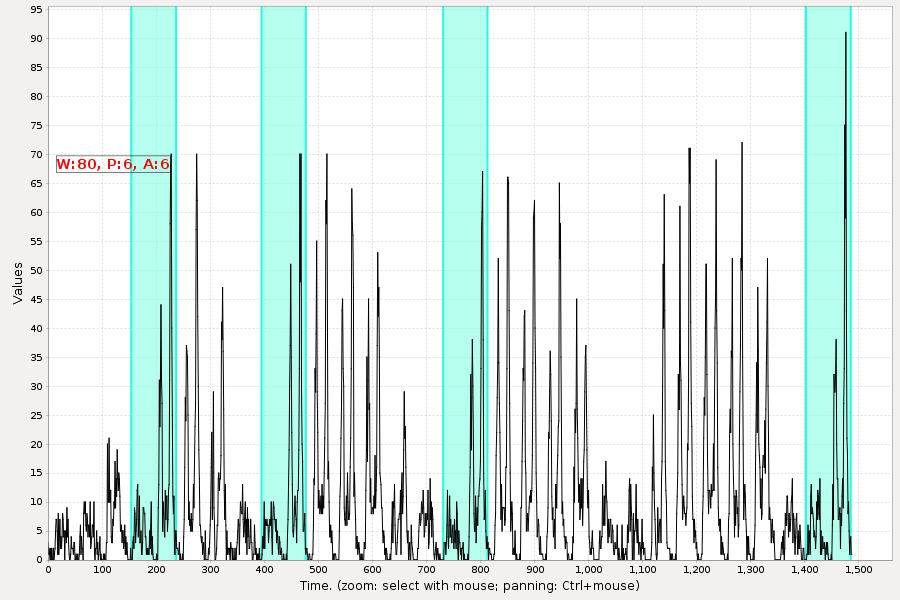
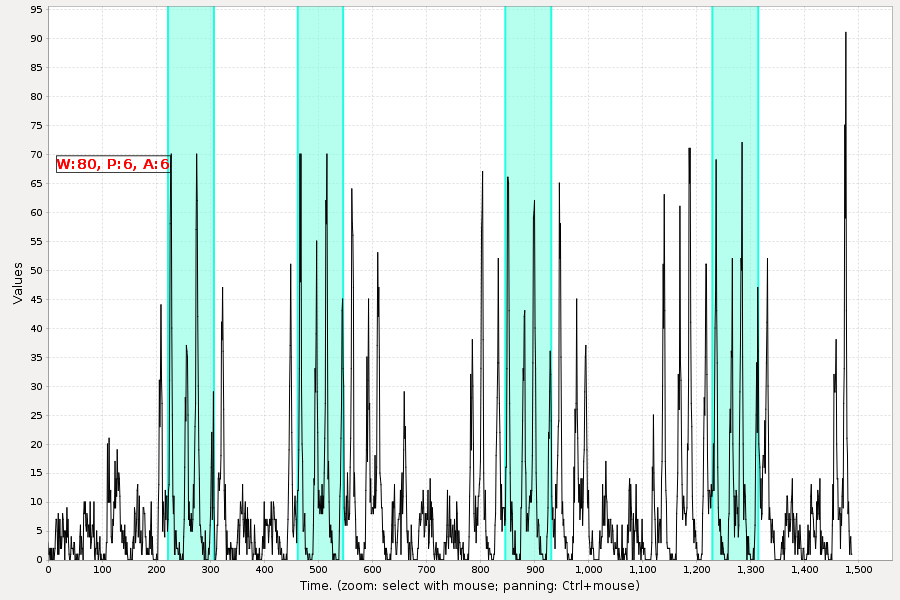

從第一張圖可以看到，星期日與星期一（圖中每個降到零的波谷為分界點，第一個波是星期六）的借車情況有高機率是類似的，且有趣的是第一張圖可以大致imply第二張圖，也許這可以代表當地居民將citibike當作日常的交通工具


再來是out_flow_count
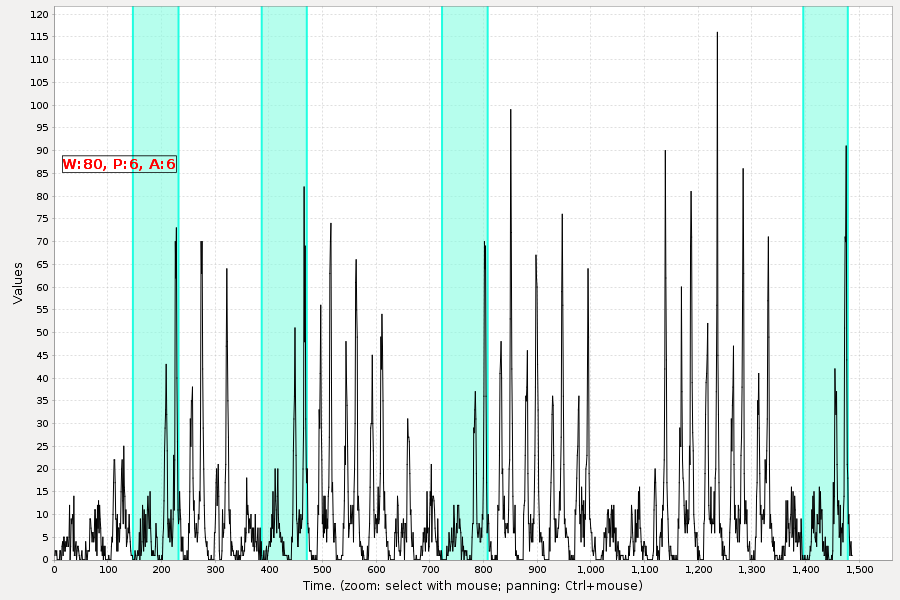
這張圖有趣的地方在週日、週一的分佈也幾乎類似，而且frequent pattern跟上面in_flow_count的第一張非常相似
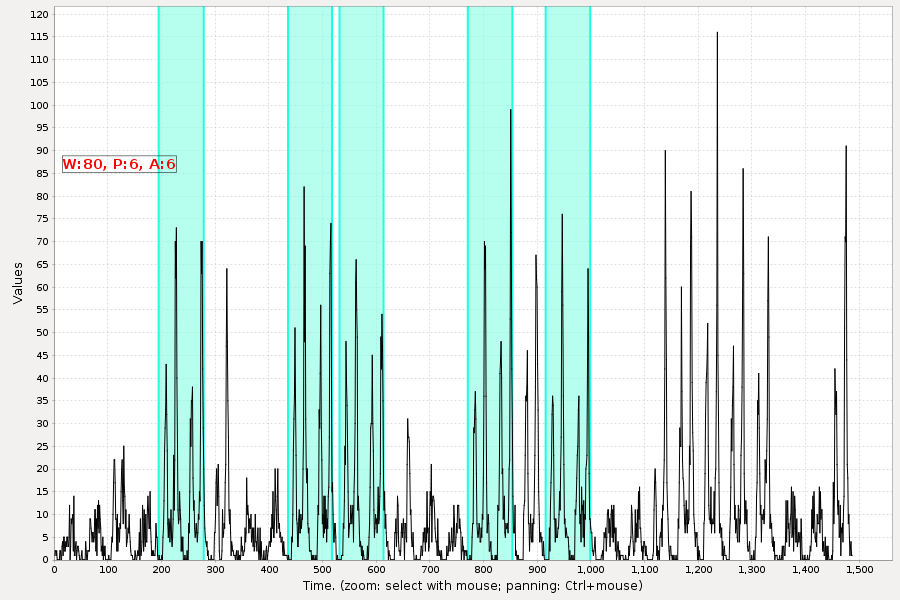
這張圖則是更加顯示citibike與居民的日常生活相關，至於後半月不一樣的原因可能要結合其他資訊才能分析出來了